<center>
    <h1>Assignment 1 - Recurrent Neural Models for Sequence Labeling</h1>
    <h2>Natural Language Processing</h2>
    <h3>Antonio Politano, Enrico Pittini, Riccardo Spolaor and Samuele Bortolato</h3>
    <h4>antonio.politano2@studio.unibo.it; enrico.pittini@studio.unibo.it, riccardo.spolaor@studio.unibo.it, samuele.bortolato@studio.unibo.it</h4>
</center>



---



Assignment description: see `Assignment1_2022.ipynb`

In [1]:
import os 
import random  

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Settings fro autoreloading

%load_ext autoreload
%autoreload 2

In [3]:
# Settings for reprodicibility

seed = 41

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# 1 Preliminaries

## 1.1 Dataset loading

The training, validation and test datasets are loaded, splitting the documents into sentences. Each dataset has the form `texts, labels`, where the former is a list of list of strings, representing the sentences words, while the latter is a list of list of strings, representing the corresponding sentences POS tags.

As preprocessing, all the words are trasformed into lowercase. Moreover, all the numbers are substituted with the same special token `[num]`. The idea is that almost most of them have the same POS tag, i.e. `CD` Cardinal Numbers, therefore they are equivalent from the POS tagging perspective.

In [4]:
from utils.dataset_loader import load_datasets

(texts_train, labels_train), (texts_val, labels_val), (texts_test, labels_test) = load_datasets(folder_path='dataset', 
                                                                                                divide_by_sentence=True,
                                                                                                group_numbers=True)


## 1.2 Vocabulary creation

The vocabulary, i.e. mapping from integers ids into words, is created from the whole corpus train+val+test. The integer id $0$ is reserved for the special padding token `''`. 

Moreover, the words in the train-val-test texts are trasformed into the corresponding integers, producing the datasets `x_train`-`x_val`-`x_test`, which are represented as list of list of integers. It is important to point out that no padding is performed yet.

In [5]:
from utils.vocabulary_builder import create_vocabulary

texts = texts_train + texts_val + texts_test

vocabulary, x = create_vocabulary(texts=texts)

x_train, x_val, x_test = (x[0:len(texts_train)], x[len(texts_train):len(texts_train)+len(texts_val)],
                                                    x[len(texts_train)+len(texts_val):])

The same procedure is now applied for the labels. The `vocabulary_labels` is created, which is a mapping from integers ids into POS tags. Also here, the integer $0$ is reserved for the special padding POS tag. Finally, the list of list of integers `y_train`-`y_val`-`y_test` are created (which are not padded).

In [6]:
from utils.vocabulary_builder import create_vocabulary

labels = labels_train + labels_val + labels_test

vocabulary_labels, y = create_vocabulary(texts=labels)

y_train, y_val, y_test = (y[0:len(labels_train)], y[len(labels_train):len(labels_train)+len(labels_val)],
                                                    y[len(labels_train)+len(labels_val):])

n_classes = len(vocabulary_labels)

# The punctuation POS tags
punctuation_tags = [',', '.', ':', '``', "''"]
# POS tags to not evaluate: punctuation tags + padding
tags_no_evaluate = punctuation_tags + ['']

## 1.3 Data Generator

The training and validation data generators are now built. The purpose of a Data Generator is to generate batches of samples, which will be used during training. The padding is performed batch-wise: each batch is padded separately, according to the maximum sequence length inside it. While the training generator is defined such that it shuffles the data before each epoch, the validation generator does not perform any shuffling.  

In [7]:
from utils.data_generator import DataGenerator

train_gen = DataGenerator(tokens=x_train, labels=y_train)

val_gen = DataGenerator(tokens=x_val, labels=y_val, shuffle=False)

Moreover, the padded versions of the whole validation and test datasets are created, which will be used for evaluating the models. 

In [8]:
x_val_padded, y_val_padded = DataGenerator(tokens=x_val, labels=y_val, batch_size=len(x_val), shuffle=False)[0]
x_test_padded, y_test_padded = DataGenerator(tokens=x_test, labels=y_test, batch_size=len(x_test), shuffle=False)[0]
x_test_padded.shape

(638, 80)

## 1.4 Analysis of the training set

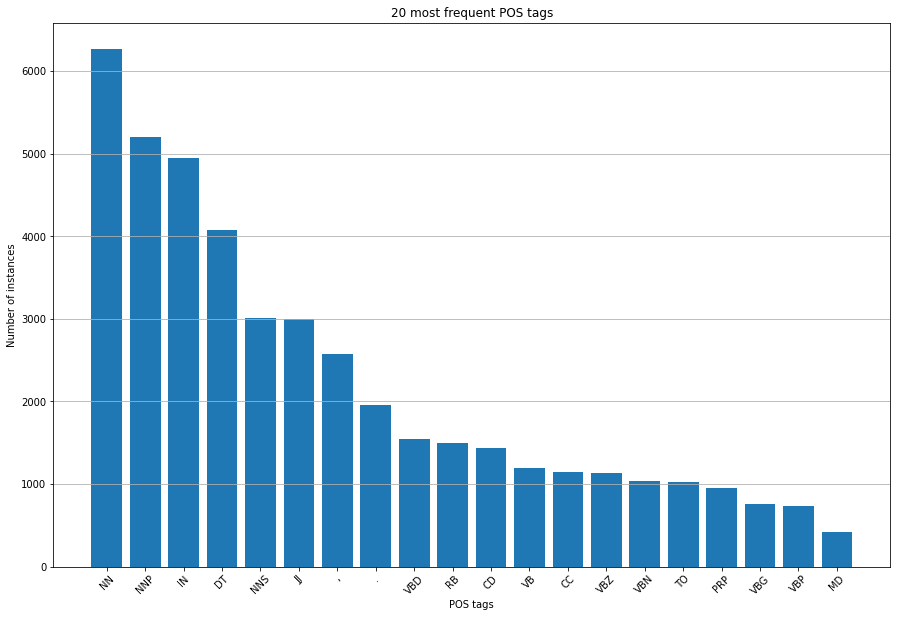

In [9]:
from utils.dataset_analysis import most_frequent_tokens_analysis 

labels_counts_dict = most_frequent_tokens_analysis(texts=labels_train, plot=True, xlabel='POS tags', title='20 most frequent POS tags')

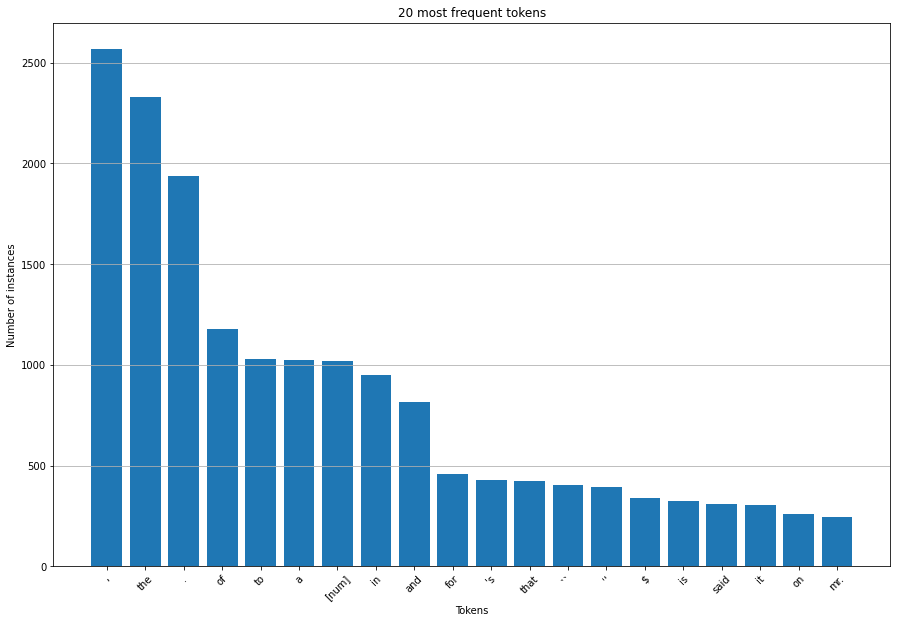

In [10]:
from utils.dataset_analysis import most_frequent_tokens_analysis 

tokens_counts_dict = most_frequent_tokens_analysis(texts=texts_train, plot=True)

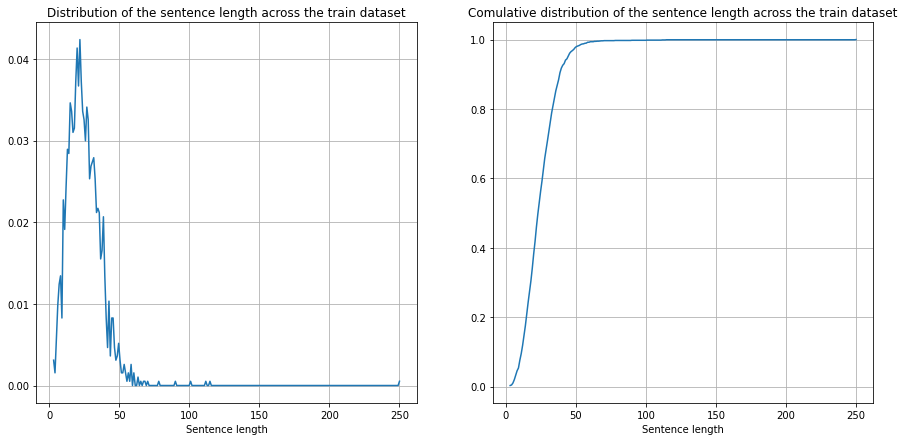

In [11]:
from utils.dataset_analysis import plot_sequence_length_analysis

plot_sequence_length_analysis(texts=texts_train)

## 1.5 Glove embeddings

The embedding model, which is the **extended GloVe embedding** in this case, is loaded, using $100$ as embedding dimension. The embedding model is implemented as a dictionary from words to the corresponding embedding vectors.

The extended GloVe embedding is the GloVe embedding which has been expanded with the training-validation-test OOV words.

In [13]:
from utils.embedding_model_handler import load_embedding_model

embedding_dimension = 100

GLOVE_embeddings = load_embedding_model(folder_path='glove_pretrained', embedding_dim=embedding_dimension, extended_version=True)

In [14]:
print(f'Embedding model size: {len(GLOVE_embeddings)}')  

Embedding model size: 400539


## 1.6 Embedding matrix

The embedding matrix, i.e. matrix whose rows correspond to the different corpus tokens and which contain the correspoding embedding vectors, is built.

In [15]:
from utils.embedding_matrix_builder import build_embedding_matrix

embedding_matrix = build_embedding_matrix(vocabulary=vocabulary, GLOVE_embeddings=GLOVE_embeddings, 
                                          embedding_dimension=embedding_dimension)

## 1.7 Training callbacks

Finally, the training callbacks are defined.
- Early stopping
- Reduce LR on Plateau

In [16]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            patience=4,
                                            min_delta=1e-3,
                                            restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience=3, min_delta=1e-3)

# 2 Models
In this section, the different considered models are illustrated.

## 2.1 First dummy classifier: majority class
We define a dummy classifier, which always returns as predicted POS tag the most frequent POS tag present in the training set.

In [17]:
most_common_label = list(labels_counts_dict.keys())[0]
most_common_label_index = np.where(vocabulary_labels==most_common_label)[0][0]
print(f'Most common POS tag ==> label : {most_common_label}; index : {most_common_label_index}')

Most common POS tag ==> label : NN; index : 1


In [18]:
# Validation f1-score

from utils.evaluate import compute_f1_score

y_pred_val = np.array([[most_common_label_index for _ in range(y_val_padded.shape[1])] for _ in range(y_val_padded.shape[0])])

f1_macro = compute_f1_score(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

print('F1 macro val: {:.3f}'.format(f1_macro))

F1 macro val: 0.007


## 2.2 Baseline Model

Model containing: 
1. an input layer;
2. a non-trainable Embedding layer, with the embedding matrix;
3. a Bidirectional LSTM layer;
4. a final dense layer, producing the output.

The output layer does not use any activation function, since the `SparseCategoricalCrossentropy(from_logits=True)` loss function is used.

The `Adam` optimizer is used, with default LR, i.e. $0.001$.

We tuned different values for the hyperparameters `latend_dim` and `dropout` of the LSTM layer. The values `latend_dim=128` and `dropout=0.2` turned out to be the best one, according to the validation f1-score.

In [19]:
from models.baseline_model import build_baseline_model

baseline_model = build_baseline_model(n_classes=n_classes, embedding_dim=embedding_dimension, embedding_matrix=embedding_matrix, dropout=0.2)

In [20]:
baseline_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1006100   
                                                                 
 bidirectional (Bidirectiona  [(None, None, 256),      234496    
 l)                           (None, 128),                       
                              (None, 128),                       
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 dense (Dense)               (None, None, 46)          11822     
                                                                 
Total params: 1,252,418
Trainable params: 246,318
Non-trainab

In [21]:
# Training callback for saving the model weigths

weigths_dir = os.path.join('weigths', 'baselineModel') 
os.makedirs(weigths_dir, exist_ok=True)

checkpoint_filepath = os.path.join(weigths_dir, 'weightsBaselineModel.{epoch:02d}-{val_loss:.2f}.hdf5') 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Training

In [22]:
baseline_model_history = baseline_model.fit(x=train_gen, epochs=50, validation_data=val_gen,
                                            callbacks=[early_stopping_callback, reduce_lr_callback, model_checkpoint_callback])

Epoch 1/50
61/61 [==============================] - 20s 160ms/step - loss: 2.4266 - accuracy: 0.3989 - val_loss: 1.5733 - val_accuracy: 0.6086 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 6s 101ms/step - loss: 1.1685 - accuracy: 0.7074 - val_loss: 0.9000 - val_accuracy: 0.7672 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 7s 109ms/step - loss: 0.7889 - accuracy: 0.7932 - val_loss: 0.6877 - val_accuracy: 0.8241 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 9s 152ms/step - loss: 0.6407 - accuracy: 0.8289 - val_loss: 0.5866 - val_accuracy: 0.8424 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 7s 108ms/step - loss: 0.5574 - accuracy: 0.8449 - val_loss: 0.5232 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 6s 101ms/step - loss: 0.5041 - accuracy: 0.8587 - val_loss: 0.4804 - val_accuracy: 0.8676 - lr: 0.0010
Epoch 7/50
61/61 [==============================] - 6s 103ms/step - l

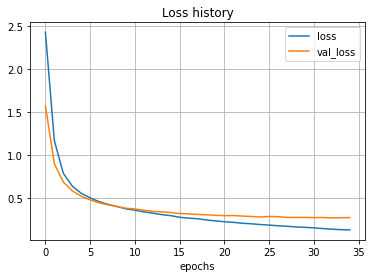

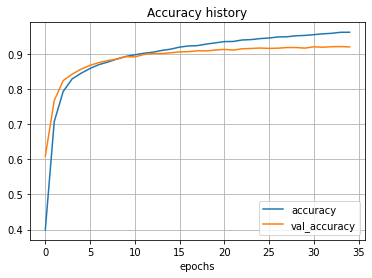

In [24]:
from utils.utils import plot_history

plot_history(baseline_model_history)

Example of predictions on a val sentence

In [27]:
print('Sentence:', ' '.join(texts_val[0]))
print()
print('True POS tags:', ' '.join(labels_val[0]))
print()
print('Predicted POS tags:', ' '.join(vocabulary_labels[np.argmax(baseline_model(x_val_padded[0:1]), axis=2)][0][:len(labels_val[0])]))

Sentence: a house-senate conference approved major portions of a package for more than $ [num] million in economic aid for poland that relies heavily on $ [num] million in credit and loan guarantees in fiscal [num] in hopes of stimulating future trade and investment .

True POS tags: DT NNP NN VBD JJ NNS IN DT NN IN JJR IN $ CD CD IN JJ NN IN NNP WDT VBZ RB IN $ CD CD IN NN CC NN NNS IN JJ CD IN NNS IN VBG JJ NN CC NN .

Predicted POS tags: DT NNP NN VBD JJ NNS IN DT NN IN JJR IN $ CD CD IN JJ NN IN NNP WDT VBZ RB IN $ CD CD IN NN CC NN NNS IN JJ CD IN NN IN JJ JJ NN CC NN .


Validation f1-score

In [28]:
y_pred_val = np.argmax(baseline_model(x_val_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

print('F1 macro val: {:.3f}'.format(f1_macro))

F1 macro val: 0.775


## 2.3 First Model

Model containing: 
1. an input layer;
2. a non-trainable Embedding layer, with the embedding matrix;
3. a Bidirectional GRU layer;
4. a final dense layer, producing the output.

The same loss function and optimizer seen before have been used. Moreover, the same best values as before for the hyperparameters have been obtained. 

In [32]:
from models.first_model import build_first_model

first_model = build_first_model(n_classes=n_classes, embedding_dim=embedding_dimension, embedding_matrix=embedding_matrix, dropout=0.2)

In [33]:
first_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 100)         1006100   
                                                                 
 bidirectional_2 (Bidirectio  [(None, None, 256),      176640    
 nal)                         (None, 128),                       
                              (None, 128)]                       
                                                                 
 dense_2 (Dense)             (None, None, 46)          11822     
                                                                 
Total params: 1,194,562
Trainable params: 188,462
Non-trainable params: 1,006,100
_________________________________________________________________


In [34]:
# Training callback for saving the model weigths

weigths_dir = os.path.join('weigths', 'firstModel') 
os.makedirs(weigths_dir, exist_ok=True)

checkpoint_filepath = os.path.join(weigths_dir, 'weightsFirstModel.{epoch:02d}-{val_loss:.2f}.hdf5') 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Training

In [35]:
first_model_history = first_model.fit(x=train_gen, epochs=50, validation_data=val_gen,
                                      callbacks=[early_stopping_callback, reduce_lr_callback, model_checkpoint_callback])

Epoch 1/50
61/61 [==============================] - 23s 160ms/step - loss: 2.1391 - accuracy: 0.4614 - val_loss: 1.1708 - val_accuracy: 0.7056 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 6s 97ms/step - loss: 0.8847 - accuracy: 0.7716 - val_loss: 0.7046 - val_accuracy: 0.8149 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 6s 95ms/step - loss: 0.6273 - accuracy: 0.8288 - val_loss: 0.5611 - val_accuracy: 0.8468 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 6s 95ms/step - loss: 0.5278 - accuracy: 0.8504 - val_loss: 0.4871 - val_accuracy: 0.8645 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 6s 91ms/step - loss: 0.4663 - accuracy: 0.8661 - val_loss: 0.4422 - val_accuracy: 0.8753 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 6s 91ms/step - loss: 0.4254 - accuracy: 0.8790 - val_loss: 0.4262 - val_accuracy: 0.8775 - lr: 0.0010
Epoch 7/50
61/61 [==============================] - 5s 86ms/step - loss: 0

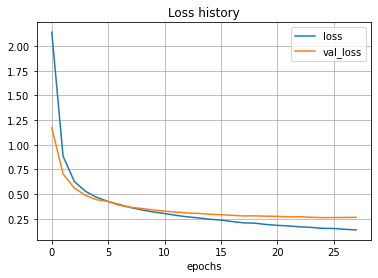

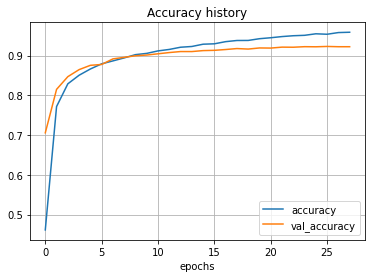

In [37]:
from utils.utils import plot_history

plot_history(first_model_history)

Example of predictions on a val sentence

In [39]:
print('Sentence:', ' '.join(texts_val[0]))
print()
print('True POS tags:', ' '.join(labels_val[0]))
print()
print('Predicted POS tags:', ' '.join(vocabulary_labels[np.argmax(first_model(x_val_padded[0:1]), axis=2)][0][:len(labels_val[0])]))

Sentence: a house-senate conference approved major portions of a package for more than $ [num] million in economic aid for poland that relies heavily on $ [num] million in credit and loan guarantees in fiscal [num] in hopes of stimulating future trade and investment .

True POS tags: DT NNP NN VBD JJ NNS IN DT NN IN JJR IN $ CD CD IN JJ NN IN NNP WDT VBZ RB IN $ CD CD IN NN CC NN NNS IN JJ CD IN NNS IN VBG JJ NN CC NN .

Predicted POS tags: DT JJ NN VBD JJ NNS IN DT NN IN JJR IN $ CD CD IN JJ NNS IN NNP WDT VBZ VBN IN $ CD CD IN NN CC NN NN IN JJ CD IN NN IN VBG JJ NN CC NN .


Validation f1-score

In [40]:
y_pred_val = np.argmax(first_model(x_val_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

print('F1 macro val: {:.3f}'.format(f1_macro))

F1 macro val: 0.785


## 2.4 Second Model

Model containing: 
1. an input layer;
2. a non-trainable Embedding layer, with the embedding matrix;
3. a Bidirectional LSTM layer;
4. another Bidirectional LSTM layer;
4. a final dense layer, producing the output.

The same loss function and optimizer seen before have been used. Moreover, the same best values as before for the hyperparameters have been obtained. 

In [41]:
from models.second_model import build_second_model

second_model = build_second_model(n_classes=n_classes, embedding_dim=embedding_dimension, embedding_matrix=embedding_matrix, dropout=0.2)

In [42]:
second_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         1006100   
                                                                 
 bidirectional_3 (Bidirectio  [(None, None, 256),      234496    
 nal)                         (None, 128),                       
                              (None, 128),                       
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 bidirectional_4 (Bidirectio  [(None, None, 256),      394240    
 nal)                         (None, 128),                       
                              (None, 128),                 

In [43]:
# Training callback for saving the model weigths

weigths_dir = os.path.join('weigths', 'secondModel') 
os.makedirs(weigths_dir, exist_ok=True)

checkpoint_filepath = os.path.join(weigths_dir, 'weightsSecondModel.{epoch:02d}-{val_loss:.2f}.hdf5') 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Training

In [44]:
second_model_history = second_model.fit(x=train_gen, epochs=50, validation_data=val_gen,
                                      callbacks=[early_stopping_callback, reduce_lr_callback, model_checkpoint_callback])

Epoch 1/50
61/61 [==============================] - 45s 413ms/step - loss: 2.6342 - accuracy: 0.2762 - val_loss: 1.8135 - val_accuracy: 0.5324 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 16s 262ms/step - loss: 1.2607 - accuracy: 0.6633 - val_loss: 0.8806 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 16s 264ms/step - loss: 0.7801 - accuracy: 0.7882 - val_loss: 0.6355 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 16s 263ms/step - loss: 0.6140 - accuracy: 0.8264 - val_loss: 0.5259 - val_accuracy: 0.8523 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 16s 265ms/step - loss: 0.5273 - accuracy: 0.8488 - val_loss: 0.4657 - val_accuracy: 0.8655 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 16s 266ms/step - loss: 0.4713 - accuracy: 0.8643 - val_loss: 0.4300 - val_accuracy: 0.8745 - lr: 0.0010
Epoch 7/50
61/61 [==============================] - 21s 352ms/st

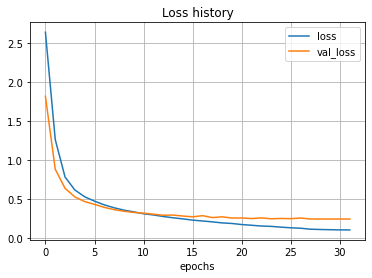

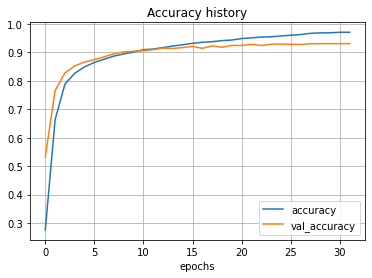

In [45]:
from utils.utils import plot_history

plot_history(second_model_history)

Example of predictions on a val sentence

In [47]:
print('Sentence:', ' '.join(texts_val[0]))
print()
print('True POS tags:', ' '.join(labels_val[0]))
print()
print('Predicted POS tags:', ' '.join(vocabulary_labels[np.argmax(second_model(x_val_padded[0:1]), axis=2)][0][:len(labels_val[0])]))

Sentence: a house-senate conference approved major portions of a package for more than $ [num] million in economic aid for poland that relies heavily on $ [num] million in credit and loan guarantees in fiscal [num] in hopes of stimulating future trade and investment .

True POS tags: DT NNP NN VBD JJ NNS IN DT NN IN JJR IN $ CD CD IN JJ NN IN NNP WDT VBZ RB IN $ CD CD IN NN CC NN NNS IN JJ CD IN NNS IN VBG JJ NN CC NN .

Predicted POS tags: DT JJ NN VBD JJ NNS IN DT NN IN JJR IN $ CD CD IN JJ NN IN NNP WDT VBZ RB IN $ CD CD IN NN CC NN NNS IN JJ CD IN NN IN VBG JJ NN CC NN .


Validation f1-score

In [48]:
y_pred_val = np.argmax(second_model(x_val_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

print('F1 macro val: {:.3f}'.format(f1_macro))

F1 macro val: 0.786


## 2.5 Third Model

Model containing: 
1. an input layer;
2. a non-trainable Embedding layer, with the embedding matrix;
3. a Bidirectional LSTM layer;
4. a Dense layer;
4. a final dense layer, producing the output.

The same loss function and optimizer seen before have been used. Moreover, the same best values as before for the hyperparameters `latent_dim` and `dropout` have been obtained. Finally, the best value obtained for the hyperparameter `units` of the first Dense lahyer is $128$.

In [49]:
from models.third_model import build_third_model

third_model = build_third_model(n_classes=n_classes, embedding_dim=embedding_dimension, embedding_matrix=embedding_matrix, dropout=0.2)

In [50]:
third_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 100)         1006100   
                                                                 
 bidirectional_5 (Bidirectio  [(None, None, 256),      234496    
 nal)                         (None, 128),                       
                              (None, 128),                       
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 dense_4 (Dense)             (None, None, 128)         32896     
                                                                 
 dense_5 (Dense)             (None, None, 46)          5934

In [51]:
# Training callback for saving the model weigths

weigths_dir = os.path.join('weigths', 'thirdModel') 
os.makedirs(weigths_dir, exist_ok=True)

checkpoint_filepath = os.path.join(weigths_dir, 'weightsThirdModel.{epoch:02d}-{val_loss:.2f}.hdf5') 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Training

In [52]:
third_model_history = third_model.fit(x=train_gen, epochs=50, validation_data=val_gen,
                                      callbacks=[early_stopping_callback, reduce_lr_callback, model_checkpoint_callback])

Epoch 1/50
61/61 [==============================] - 24s 173ms/step - loss: 2.2020 - accuracy: 0.4321 - val_loss: 1.2011 - val_accuracy: 0.6763 - lr: 0.0010
Epoch 2/50
61/61 [==============================] - 7s 121ms/step - loss: 0.8901 - accuracy: 0.7613 - val_loss: 0.6766 - val_accuracy: 0.8189 - lr: 0.0010
Epoch 3/50
61/61 [==============================] - 7s 117ms/step - loss: 0.6210 - accuracy: 0.8246 - val_loss: 0.5397 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 4/50
61/61 [==============================] - 7s 107ms/step - loss: 0.5201 - accuracy: 0.8499 - val_loss: 0.4756 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 5/50
61/61 [==============================] - 7s 113ms/step - loss: 0.4595 - accuracy: 0.8662 - val_loss: 0.4285 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 6/50
61/61 [==============================] - 7s 110ms/step - loss: 0.4127 - accuracy: 0.8774 - val_loss: 0.3945 - val_accuracy: 0.8863 - lr: 0.0010
Epoch 7/50
61/61 [==============================] - 6s 105ms/step - l

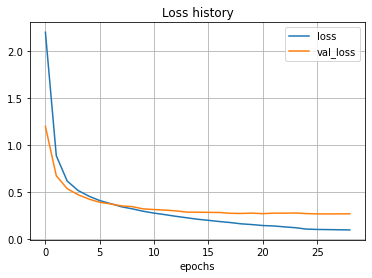

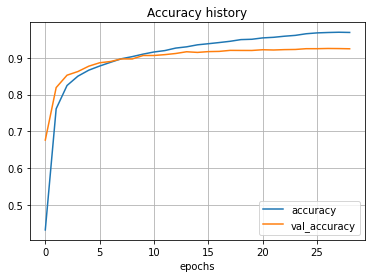

In [53]:
from utils.utils import plot_history

plot_history(third_model_history)

Example of predictions on a val sentence

In [54]:
print('Sentence:', ' '.join(texts_val[0]))
print()
print('True POS tags:', ' '.join(labels_val[0]))
print()
print('Predicted POS tags:', ' '.join(vocabulary_labels[np.argmax(third_model(x_val_padded[0:1]), axis=2)][0][:len(labels_val[0])]))

Sentence: a house-senate conference approved major portions of a package for more than $ [num] million in economic aid for poland that relies heavily on $ [num] million in credit and loan guarantees in fiscal [num] in hopes of stimulating future trade and investment .

True POS tags: DT NNP NN VBD JJ NNS IN DT NN IN JJR IN $ CD CD IN JJ NN IN NNP WDT VBZ RB IN $ CD CD IN NN CC NN NNS IN JJ CD IN NNS IN VBG JJ NN CC NN .

Predicted POS tags: DT JJ NN VBD JJ NNS IN DT NN IN JJR IN $ CD CD IN JJ NN IN NNP WDT VBZ RB IN $ CD CD IN NN CC NN NN IN JJ CD IN NN IN VBG JJ NN CC NN .


Validation f1-score

In [55]:
y_pred_val = np.argmax(third_model(x_val_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_val_padded, y_pred=y_pred_val, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

print('F1 macro val: {:.3f}'.format(f1_macro))

F1 macro val: 0.783


# 3 Best model and Error Analysis
In this section, the best model is selected, and an error analysis is performed.

## 3.1 Test score of the two best models
The two best models are the first and second model, since they reach the best f1-score on the validations set. Now, these two models are evaluated on the test set.

#### First model

In [59]:
# Test accuracy 

_, test_accuracy = first_model.evaluate(x_test_padded, y_test_padded)
print(f'Test accuracy first model : {test_accuracy:.2f}')

20/20 [==============================] - 1s 31ms/step - loss: 0.2559 - accuracy: 0.9235
Test accuracy first model : 0.92


In [60]:
# f1-score

y_pred_test = np.argmax(first_model(x_test_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_test_padded, y_pred=y_pred_test, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

print('First model f1 macro score: {:.3f}'.format(f1_macro))

First model f1 macro score: 0.859


#### Second model

In [62]:
# Test accuracy 

_, test_accuracy = second_model.evaluate(x_test_padded, y_test_padded)
print(f'Test accuracy second model : {test_accuracy:.2f}')

20/20 [==============================] - 2s 80ms/step - loss: 0.2302 - accuracy: 0.9348
Test accuracy second model : 0.93


In [61]:
# f1-score

y_pred_test = np.argmax(second_model(x_test_padded), axis=2)

f1_macro = compute_f1_score(y_true=y_test_padded, y_pred=y_pred_test, tags_no_evaluate=tags_no_evaluate,
                            vocabulary_labels=vocabulary_labels)

print('Second model f1 macro score: {:.3f}'.format(f1_macro))

Second model f1 macro score: 0.848


## 3.2 Error analysis

In [63]:
from utils.evaluate import compute_class_report, wrongly_classified_tokens_analysis, wrongly_classified_sentences_analysis

#### Validation set

In [64]:
y_val_pred = np.argmax(first_model(x_val_padded), axis=2)

Classification report

              precision    recall  f1-score   support

          NN       0.87      0.89      0.88      4512
          IN       0.98      0.97      0.97      3275
         NNP       0.88      0.88      0.88      2703
          DT       0.98      0.99      0.99      2754
         NNS       0.90      0.91      0.91      2102
          JJ       0.81      0.80      0.81      1923
          CD       0.96      0.98      0.97      1249
         VBD       0.89      0.93      0.91       861
          RB       0.85      0.85      0.85       951
          VB       0.91      0.92      0.92       956
          CC       1.00      0.98      0.99       758
          TO       1.00      1.00      1.00       765
         VBN       0.84      0.79      0.82       737
         VBZ       0.97      0.94      0.96       712
         PRP       0.99      0.99      0.99       570
         VBG       0.79      0.83      0.81       475
         VBP       0.86      0.88      0.87       460
          MD       0.98    

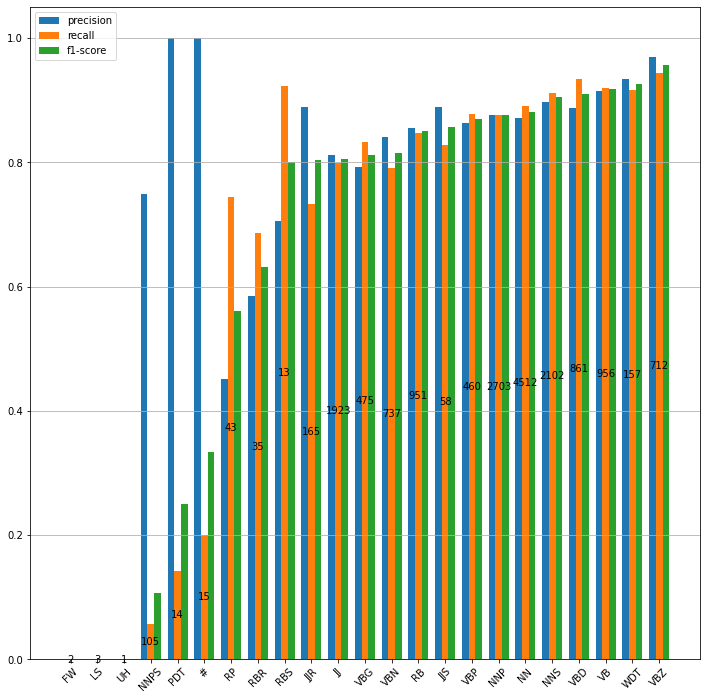

In [66]:
class_report = compute_class_report(y_true=y_val_padded, y_pred=y_val_pred, tags_no_evaluate=tags_no_evaluate, 
                     vocabulary_labels=vocabulary_labels, show=True, plot=True, k=n_classes//2)

Worst misclassified tokens

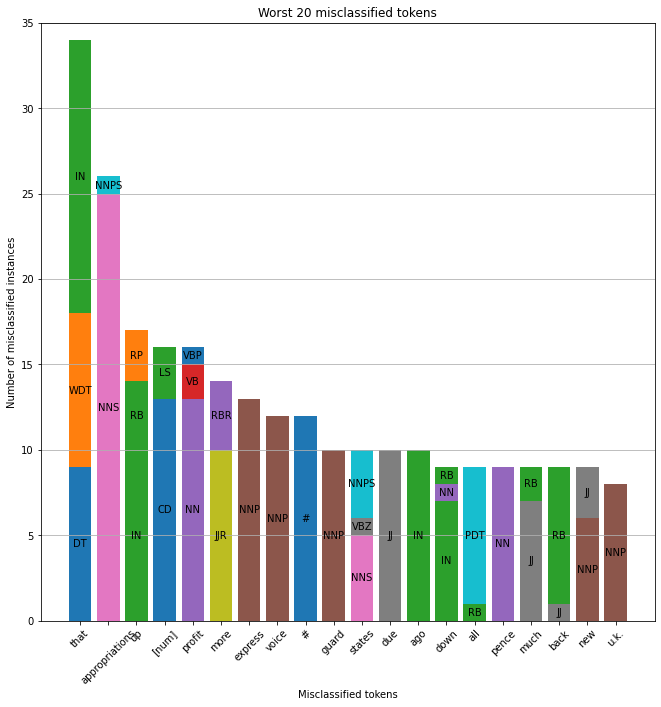

In [68]:
wrong_tokens_dict, wrong_tokens_tags_df = wrongly_classified_tokens_analysis(x=x_val_padded, y_true=y_val_padded, 
                                                                             y_pred=y_val_pred, 
                                                                             tags_no_evaluate=tags_no_evaluate, 
                                                                             vocabulary_labels=vocabulary_labels, 
                                                                             vocabulary=vocabulary, plot=True)

Worst classified sentences

In [86]:
worst_sentences_dict = wrongly_classified_sentences_analysis(x=x_val_padded, y_true=y_val_padded, y_pred=y_val_pred, 
                                                             tags_no_evaluate=tags_no_evaluate, 
                                                             vocabulary_labels=vocabulary_labels, use_absolute_error=False,
                                                             vocabulary=vocabulary, show=True, k=5)

LEGEND
	 word: correctly classified word
	 word[TRUE_TAG/WRONG_TAG]: misclassified word
	 word: non-evaluated word (i.e. punctuation)

1) Sentence index 993
Relative error: 1.00
n.v[NN/NNP] . 

2) Sentence index 278
Relative error: 0.50
source[NN/NNP] : telerate systems[NNPS/NNP] inc . 

3) Sentence index 257
Relative error: 0.50
discount[NNP/NN] rate[NNP/NN] : [num] % . 

4) Sentence index 280
Relative error: 0.50
source[NN/NNP] : telerate systems[NNPS/NNP] inc . 

5) Sentence index 368
Relative error: 0.47
the worst crop damage[NN/NNS] occurred[VBD/NN] in the midwestern[NNP/JJ] corn[NNP/NN] belt[NNP/NN] and the northern[JJ/NNP] great plains[NNPS/NNP] . 



In [87]:
worst_sentences_dict = wrongly_classified_sentences_analysis(x=x_val_padded, y_true=y_val_padded, y_pred=y_val_pred, 
                                                             tags_no_evaluate=tags_no_evaluate, 
                                                             vocabulary_labels=vocabulary_labels, use_absolute_error=True,
                                                             vocabulary=vocabulary, show=True, k=5)

LEGEND
	 word: correctly classified word
	 word[TRUE_TAG/WRONG_TAG]: misclassified word
	 word: non-evaluated word (i.e. punctuation)

1) Sentence index 336
Error count: 14
perhaps none[NN/RB] of the unconstitutional[JJ/NN] conditions contained in the appropriations[NNS/NN] bills for fiscal [num] better[RBR/VBP] illustrates congress 's attempt to usurp executive[JJ/NN] power than section [num] of the executive-office[NN/NNS] bill[NN/NNP] : `` none[NN/RB] of the funds made[VBN/VBD] available[JJ/RB] pursuant to the provisions of this act shall be used to implement , administer , or enforce any regulation which has been disapproved pursuant[JJ/VBN] to a resolution of disapproval duly[RB/VBN] adopted in accordance[NN/VBN] with the applicable law of the united states[NNPS/NNP] . 

2) Sentence index 834
Error count: 9
maryland community development administration , department[NNP/NN] of housing and community development[NNP/NN] -- $ [num] million of single-family[NN/JJ] program bonds , [num]

#### Test set

In [72]:
y_test_pred = np.argmax(first_model(x_test_padded), axis=2)

Classification report

              precision    recall  f1-score   support

          NN       0.89      0.87      0.88      2383
          IN       0.97      0.96      0.97      1630
         NNP       0.88      0.88      0.88      1502
          DT       0.99      0.99      0.99      1335
         NNS       0.87      0.92      0.89       941
          JJ       0.81      0.81      0.81       918
          CD       0.97      0.99      0.98       858
         VBD       0.91      0.94      0.92       634
          RB       0.83      0.82      0.83       381
          VB       0.93      0.97      0.95       403
          CC       0.99      0.99      0.99       366
          TO       1.00      1.00      1.00       386
         VBN       0.86      0.78      0.82       366
         VBZ       0.94      0.95      0.94       280
         PRP       0.98      0.99      0.99       192
         VBG       0.80      0.84      0.82       221
         VBP       0.90      0.86      0.88       134
          MD       0.96    

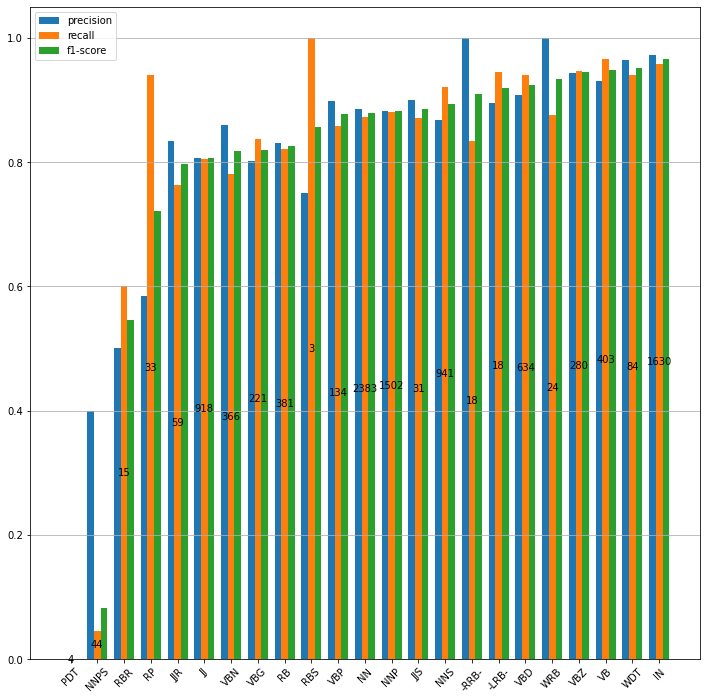

In [73]:
class_report = compute_class_report(y_true=y_test_padded, y_pred=y_test_pred, tags_no_evaluate=tags_no_evaluate, 
                     vocabulary_labels=vocabulary_labels, show=True, plot=True, k=n_classes//2)

Worst misclassified tokens

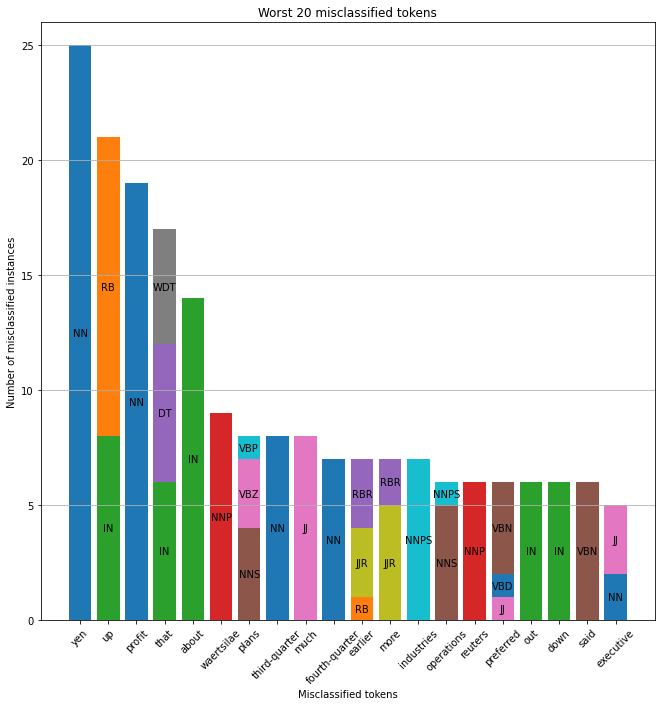

In [74]:
wrong_tokens_dict, wrong_tokens_tags_df = wrongly_classified_tokens_analysis(x=x_test_padded, y_true=y_test_padded, 
                                                                             y_pred=y_test_pred, 
                                                                             tags_no_evaluate=tags_no_evaluate, 
                                                                             vocabulary_labels=vocabulary_labels, 
                                                                             vocabulary=vocabulary, plot=True)

Worst classified sentences

In [88]:
worst_sentences_dict = wrongly_classified_sentences_analysis(x=x_test_padded, y_true=y_test_padded, y_pred=y_test_pred, 
                                                             tags_no_evaluate=tags_no_evaluate, 
                                                             vocabulary_labels=vocabulary_labels, use_absolute_error=False,
                                                             vocabulary=vocabulary, show=True, k=5)

LEGEND
	 word: correctly classified word
	 word[TRUE_TAG/WRONG_TAG]: misclassified word
	 word: non-evaluated word (i.e. punctuation)

1) Sentence index 443
Relative error: 0.50
inter-tel[NNP/NN] inc . 

2) Sentence index 352
Relative error: 0.44
dollar : [num] yen[NN/NNS] , up[RB/IN] [num] ; [num] marks[NNS/NN] , up[RB/IN] [num] . 

3) Sentence index 350
Relative error: 0.43
dow jones industrials[NNS/NNP] [num] , up[RB/IN] [num] ; transportation[NN/NNP] [num][CD/NNP] , up[RB/IN] [num] ; utilities [num] , up[RB/IN] [num] . 

4) Sentence index 414
Relative error: 0.43
h.[NN/NNP] plant[NN/NNP] engineering[VBG/NN] unit , the company said . 

5) Sentence index 192
Relative error: 0.38
nissan scheduled[VBD/VB] a seven-yen interim[JJ/NN] dividend payment , unchanged[JJ/NNS] . 



In [89]:
worst_sentences_dict = wrongly_classified_sentences_analysis(x=x_test_padded, y_true=y_test_padded, y_pred=y_test_pred, 
                                                             tags_no_evaluate=tags_no_evaluate, 
                                                             vocabulary_labels=vocabulary_labels, use_absolute_error=True,
                                                             vocabulary=vocabulary, show=True, k=5)

LEGEND
	 word: correctly classified word
	 word[TRUE_TAG/WRONG_TAG]: misclassified word
	 word: non-evaluated word (i.e. punctuation)

1) Sentence index 474
Error count: 9
absorbed in doling out `` feeding[NNP/VBG] frenzy[NNP/NN] 's '' tidbits , the authors gloss over the root causes[NNS/NN] of wedtech[NNP/NN] , namely[RB/VBG] the section [num] -lrb- a[NN/DT] -rrb-[-RRB-/NNP] federal[JJ/NNP] program under whose auspices[NNS/VBN] the scandal took place . 

2) Sentence index 450
Error count: 8
bribe by bribe , mr. sternberg and his co-author , matthew c. harrison jr. , lead[VBP/VBG] us along the path[NN/NNP] wedtech[NNP/NN] traveled[VBD/VBN] , from its inception as a small manufacturing[VBG/NN] company to the status of full-fledged defense contractor , entrusted[VBN/VBG] with the task of producing vital equipment[NN/NNS] for the army[NNP/NN] and navy . 

3) Sentence index 156
Error count: 8
'' other rumored[VBN/JJ] takeover and restructuring[VBG/NN] candidates to attract buyers included[